This is a simple example of simulating a biophysical neuron network with exponential integrate-and-fire (EIF) neurons.

All parameters and equations are from the following paper:

Huang, C., Ruff, D. A., Pyle, R., Rosenbaum, R., Cohen, M. R., & Doiron, B. (2019). Circuit models of low-dimensional shared variability in cortical networks. Neuron, 101(2), 337-348.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Below I model a network of two population and 100 neurons in total, with 50 neurons in each population. 

In [12]:
# Unit: mV or ms
tau = 15  # Membrane time constant
EL = -60  # Resting potential
VT = -50  # Exponential term threshold; see Eq. 3 in Huang et al. (2019)
Vth = -10 # Spike threshold
Vre = -65 # Reset potential
DltT = 2  # Exponential term slope factor; see Eq. 3 in Huang et al. (2019)
tau_ref = 1 # Refractory period
tau_d = 5 # Synaptic decay time constant
tau_r = 1 # Synaptic rise time constant

# Simulation parameters
total_time = 500 # Total simulation time (ms)
dt = 0.1 # Time step (ms)
ndt = int(1/dt) # Number of steps per ms
nt = total_time*ndt # Total simulation time steps
npadding = 100*ndt # Padding time steps, making sure the network is in steady state before recording
nt_tot = nt + npadding # Total time steps with padding
bin_size = 1 # Bin size for spike recording (ms)
noise_amp = 1.0 # Noise amplitude

# Network parameters
nneuron = 100 # Number of neurons
ntrial = 200 # Number of trials
cross_population_conn = 0.001 # Connection strength
within_population_conn = 0.005

# Define connectivity matrix
# Assuming the connectivity follows log-normal distribution (Sen Song et al., 2005)
J = np.zeros((nneuron, nneuron)) # Element J_ij is the connection strength from neuron i to neuron j
nneuron_part = int(nneuron/2) # Number of neurons in each population
# Connectivity from population 1 to population 2
J[0:nneuron_part,nneuron_part:] = np.random.lognormal(
    mean=np.log(cross_population_conn), sigma=0.4, size=(nneuron_part, nneuron_part)
)
# Connectivity within population 1
J[0:nneuron_part,0:nneuron_part] = np.random.lognormal(
    mean=np.log(within_population_conn), sigma=0.4, size=(nneuron_part, nneuron_part)
)
# Connectivity within population 2
J[nneuron_part:,nneuron_part:] = np.random.lognormal(
    mean=np.log(within_population_conn), sigma=0.4, size=(nneuron_part, nneuron_part)
)

# Define synaptic kernel
# Assuming the synaptic kernel is identical for all synapses
nsyn_func = 3*tau_d*ndt
syn_time_line = np.arange(nsyn_func)
syn_func = (np.exp(-syn_time_line*dt/tau_d)-np.exp(-syn_time_line*dt/tau_r))[:, np.newaxis]
ntau_ref = tau_ref*ndt

# External input (e.g.: dual peak input)
# Define parameters for the two peaks
peak1_time = 50*ndt + npadding  # First peak at 100ms
peak2_time = 250*ndt + npadding  # Second peak at 300ms
peak_width = 10*ndt   # Width of each peak
peak_amp = 0.2        # Amplitude of peaks
baseline = 0.0        # Baseline input level
# Create time array
t = np.arange(nt_tot)[:,np.newaxis,np.newaxis]
# Generate input with two Gaussian peaks
I_ext = baseline + peak_amp * (
    np.exp(-(t - peak1_time)**2 / (2*peak_width**2)) + 
    np.exp(-(t - peak2_time)**2 / (2*peak_width**2))
)

# Repeat for all neurons and trials
I_ext = np.repeat(I_ext, nneuron, axis=1)
I_ext = np.repeat(I_ext, ntrial, axis=2)

# Initialize spike recording array (excluding padding period)
spikes_rcd = np.zeros((int(nt/ndt/bin_size), nneuron, ntrial))

# Run simulation
for itrial in tqdm(range(ntrial)):
    # Initialize state variables
    V = Vre*np.ones((nt_tot, nneuron))
    I_syn = np.zeros((nt_tot+nsyn_func+1, nneuron))
    spikes = np.zeros((nt_tot, nneuron))

    # Time evolution
    for t in range(1, nt_tot):
        # Calculate currents
        I_leak = -dt/tau*(V[t-1,:]-EL) + dt/tau*DltT*np.exp((V[t-1,:]-VT)/DltT)
        I_noise = np.random.normal(0, noise_amp**2, nneuron)
        dV = I_leak + I_noise + I_syn[t,:] + I_ext[t,:,itrial]
        V[t,:] = V[t-1,:] + dV

        # Spike detection and reset
        spikes[t,:] = (V[t,:]>=Vth).astype(int)
        I_syn[(t+1):(t+nsyn_func+1),:] += spikes[t:(t+1),:]@J*syn_func

        # Refractory period
        in_ref = ((spikes[max(0,t-ntau_ref):(t+1),:].sum(axis=0))>0).astype(int)
        V[t,:] += in_ref*(Vre-V[t,:])

        # Record spikes in bins (only after padding period)
        if t >= npadding and (t-npadding) % (ndt*bin_size) == 0:
            time_idx = (t-npadding) // (ndt*bin_size)
            spikes_rcd[time_idx,:,itrial] = spikes[t-ndt*bin_size+1:t+1,:].sum(axis=0)


100%|██████████| 200/200 [00:26<00:00,  7.55it/s]


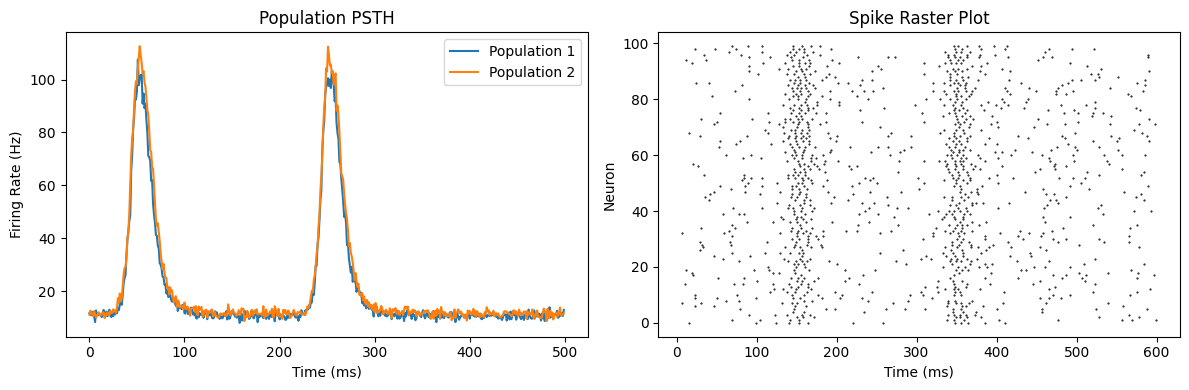

In [13]:
# Plot results
plt.figure(figsize=(12,4))

# Plot PSTH for both populations
plt.subplot(121)
t_plot = np.arange(int(nt/ndt/bin_size))*bin_size
pop1_psth = spikes_rcd[:,:nneuron//2,:].mean(axis=(1,2))*1000/bin_size  # Convert to Hz
pop2_psth = spikes_rcd[:,nneuron//2:,:].mean(axis=(1,2))*1000/bin_size
plt.plot(t_plot, pop1_psth, label='Population 1')
plt.plot(t_plot, pop2_psth, label='Population 2')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Population PSTH')
plt.legend()

# Plot raster plot
plt.subplot(122)
t_spikes = []
n_spikes = []
for n in range(nneuron):
    spike_times = np.where(spikes[:,n])[0]*dt
    t_spikes.extend(spike_times)
    n_spikes.extend([n]*len(spike_times))
    
plt.plot(t_spikes, n_spikes, '.k', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('Spike Raster Plot')

plt.tight_layout()
plt.show()